Jupyter started by Gijs, copy past from others, with a little bit of my self ;-)
27-9-2021
Used to do some basic ADC testing.
- Plot SST
- Calculate SNR
- Calculate SFDR

In [414]:
#
# Use this / these inputs
#
nof_node_unb2c = 4
nof_si_node = 12
unb2_brd = 2
unb2_node = 3
si_start=0
si_stop=3

In [178]:
#
# Imports
#
import time
if 0:
    from bokeh.plotting import figure 
    from bokeh.io import output_notebook, show
import numpy as np
import pylab as pl
#
# Open de OPC-UA devices
#
pcc=DeviceProxy("LTS/PCC/1")
sst=DeviceProxy("LTS/SST/1")
sdp=DeviceProxy("LTS/SDP/1")
#sdp.off(),sdp.initialise(), sdp.on()
#sst.initialise(), sst.on()
#
# Check PCC interface
#
state = str(pcc.state())
if state == "OFF":
    pcc.initialise()
    time.sleep(1)
state = str(pcc.state())
if state == "STANDBY":
    pcc.on()
state = str(pcc.state())
if state == "ON":
    print("Device is now in on state")
#
# Check is device is running or else start it up
#
unb2c=DeviceProxy("LTS/UNB2/1")
state = str(unb2c.state())

if state == "OFF" or state == "FAULT":
    unb2c.initialise()
    time.sleep(1)
state = str(unb2c.state())
if state == "STANDBY":
    unb2c.on()
state = str(unb2c.state())
if state == "ON":
    print("Device is now in on state")
else:
    print("warning, expected device to be in on state, is: ", state)
#
# Check SST Device and switch on if off.
#
state = str(sst.state())
if state == "OFF":
    sst.initialise()
    time.sleep(1)
state = str(pcc.state())
if state == "STANDBY":
    sst.on()
state = str(sst.state())
if state == "ON":
    print("Device is now in on state")

Device is now in on state
Device is now in on state
Device is now in on state


In [179]:
#
# Set the SST device in the right mode
#
if 0:
    sst.set_defaults() 
print(sst.FPGA_sst_offload_enable_R)
print(sst.FPGA_sst_offload_hdr_eth_destination_mac_R)
sst.FPGA_sst_offload_hdr_eth_destination_mac_RW = ('', '', '', '', '', '', '', '', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '', '', '', '')
print(sst.FPGA_sst_offload_hdr_eth_destination_mac_R)

[False False False False False False False False False False False  True
 False False False False]
('', '', '', '', '', '', '', '', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '00:1b:21:71:76:b9', '6c:2b:59:97:be:dd', '', '', '', '')
('', '', '', '', '', '', '', '', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '6c:2b:59:97:be:dd', '', '', '', '')


In [180]:
#
# Check /  set monitor rate
#    
print("Monitoring rate is: {}".format(pcc.RCU_monitor_rate_RW))
pcc.RCU_monitor_rate_RW = 1
time.sleep(2)
print("New monitoring rate is: {}".format(pcc.RCU_monitor_rate_RW))

Monitoring rate is: 1
New monitoring rate is: 1


In [415]:
#
# set RCU to basic mode
#
New_att_value = 10
new_lba_band = 1
pcc.RCU_mask_RW = [False]*4 + [True]*2 + [False]*26
pcc.Ant_mask_RW = np.array([[False]*3]*4 + [[True]*3]*2 + [[False]*3]*26)
time.sleep(2)
default_attenuator = np.array([[21]*3]*32)
default_band = np.array([[new_lba_band]*3]*32)
for rcu_cnt in range(32):
    if pcc.RCU_temperature_R[rcu_cnt] > 1:
        for channel_cnt in range(3):
            default_attenuator[rcu_cnt][channel_cnt]=New_att_value
pcc.RCU_attenuator_RW = default_attenuator
pcc.RCU_band_RW = default_band
time.sleep(2)
#
# Readback to check the modifications
#
for rcu_cnt in range(32):
    if pcc.RCU_temperature_R[rcu_cnt] > 1:
        stri = "RCU in slot {}, Temp: {:2.2f}°C ".format(rcu_cnt, pcc.RCU_temperature_R[rcu_cnt]-273.15)
        stri += "ADC lock: {} ".format(pcc.RCU_ADC_lock_R[rcu_cnt])
        stri += "Attenuator: {} ".format(pcc.RCU_attenuator_RW[rcu_cnt])
        stri += "Band: {}".format(pcc.RCU_band_RW[rcu_cnt])
        print(stri)

RCU in slot 4, Temp: 64.73°C ADC lock: [129 129 129] Attenuator: [10 10 10] Band: [1 1 1]
RCU in slot 5, Temp: 61.76°C ADC lock: [129 129 129] Attenuator: [10 10 10] Band: [1 1 1]


In [416]:
#
# Check FPGA input
#
node=(unb2_brd*nof_node_unb2c+unb2_node)
for si in range(si_start,si_stop):
    stri = "Node {} signal input {} WG status {}, Processing {}".format(node, si, sdp.FPGA_wg_enable_RW[node][si], sdp.FPGA_processing_enable_R[node])
    print(stri)

Node 11 signal input 0 WG status False, Processing True
Node 11 signal input 1 WG status False, Processing True
Node 11 signal input 2 WG status False, Processing True


In [417]:
#
# Power per input
#
for ant in range((unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_start,(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_stop):
    tot_power = ((10*np.log10(np.sum(sst.sst_r[ant]))-128-6*4))
    stri = " Total power signal input {} = {:2.2f} dB".format(ant, tot_power)
    print(stri)

 Total power signal input 132 = -6.69 dB
 Total power signal input 133 = -6.69 dB
 Total power signal input 134 = -51.25 dB


In [455]:
#
# Check SNR using Peppi & Kokki methode
#
# Methode 1 = Sum noise, should be the best but is not working (yet)
# Methode 2 = Median noise
# Methode 3 = lowest point as this is more or less the ADC noise level Optimistic :-)
#
start_bin = 2 # remove DC-offset
stop_bin = 512 # remove Ditter source
print_methode = 1
stri = "Methode {} is used".format(print_methode)
print(stri)

sst_cor_factor = ((200E6/512)*(2**14)*(2**14)*8) #/ 10**((128+6*4)/10)
sst_cor_factor = sst_cor_factor * sst.integration_interval_R[(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node] 
for ant in range((unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_start,(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_stop):
    sort_sst = np.sort(sst.sst_r[ant][start_bin:stop_bin]) / sst_cor_factor
    sig_pwr = np.sum(sort_sst[1:])
    db_sig_pwr = 10*np.log10(sig_pwr)
    if print_methode == 2:
# Methode sum
        noise_pwr = np.sum(sort_sst[:5])
        snr = 10*np.log10(sig_pwr/noise_pwr)
        enob = snr/6.02
        stri = "Signal input {} has a signal power of {:5.2f} dBFS --> est. SNR of {:5.2f} dB which results in a ENOB of {:5.2f} bits".format(ant, db_sig_pwr, snr, enob)
        print(stri)
    elif print_methode == 2:
# Methode median (avarage) noise level
        median_noise_level = 10*np.log10(np.median(sort_sst))
        snr_2 = 10*np.log10(sig_pwr) - median_noise_level - 5*np.log10(512)
        enob_2 = snr_2/6.02
        stri = "Signal input {} Psignal {:5.2f} dBFS, Noise level: {:5.2f} dB, est. SNR: {:5.2f} dB ext. ENOB {:5.2f} bit".format(ant, db_sig_pwr, median_noise_level, snr_2, enob_2)
        print(stri)
    else :
# Methode ADC noise level
        min_noise_level = 10*np.log10(np.min(sort_sst))
        snr_3 = 10*np.log10(sig_pwr) - min_noise_level - 5*np.log10(512)
        enob_3 = snr_3/6.02
        stri = "Signal input {} Psignal {:5.2f} dBFS, ADC Noise level: {:5.2f} dB, est. SNR: {:5.2f} dB ext. ENOB {:5.2f} bit".format(ant, db_sig_pwr, min_noise_level, snr_3, enob_3)
        print(stri)     

Methode 1 is used
Signal input 132 Psignal -3.92 dBFS, ADC Noise level: -96.57 dB, est. SNR: 79.11 dB ext. ENOB 13.14 bit
Signal input 133 Psignal -3.92 dBFS, ADC Noise level: -96.57 dB, est. SNR: 79.11 dB ext. ENOB 13.14 bit
Signal input 134 Psignal -67.85 dBFS, ADC Noise level: -96.89 dB, est. SNR: 15.49 dB ext. ENOB  2.57 bit


In [452]:
#
# Print a harmonic table with the 3 strong frequencies
#
print("Harmonic Table")
print("|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|")
print("| Signal  |  Freq. 1  |  Power 1  |  Freq. 2  |  Power 2  |  Freq. 3  |  Power 3  |    SFDR   |")
print("|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|")
start_bin = 1 # remove DC-offset
stop_bin = 511 # remove Ditter source
freq_table=np.zeros((5*4*12, 4, 2))
for ant in range((unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_start,(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_stop):
    sort_sst = np.sort(sst.sst_r[ant][start_bin:stop_bin])
    stri = "|    {}  |".format(ant) 
    for harm in range(1,4):
        index = np.where( sst.sst_r[ant] == sort_sst[-harm] )
        stri +=" {:5.1f} MHz |".format(f_as[index[0][0]] )
        stri +=" {:5.1f} dB  |".format(10*np.log10(sort_sst[-harm]+1)-128-6*4)
        freq_table[ant][harm][0]=(f_as[index[0][0]])
        freq_table[ant][harm][1]=(10*np.log10(sort_sst[-harm]+1)-128-6*4)
        sfdr = 10*np.log10(sort_sst[-1])-10*np.log10(sort_sst[-2])
    stri +=" {:5.1f} dB  |".format(sfdr)
    print(stri)
print("|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|")

Harmonic Table
|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| Signal  |  Freq. 1  |  Power 1  |  Freq. 2  |  Power 2  |  Freq. 3  |  Power 3  |    SFDR   |
|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|    132  |  25.0 MHz |  -6.7 dB  |  50.0 MHz | -74.2 dB  |  75.0 MHz | -83.8 dB  |  67.5 dB  |
|    133  |  25.0 MHz |  -6.7 dB  |  50.0 MHz | -74.2 dB  |  75.0 MHz | -83.8 dB  |  67.5 dB  |
|    134  |  25.0 MHz | -79.3 dB  |  97.9 MHz | -89.2 dB  |  16.2 MHz | -96.7 dB  |   9.9 dB  |
|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|


Ant. 132 Max power is -6.69 dB, Min. power -99.33 dB, Power at 50 MHz -97.48 dB
Ant. 133 Max power is -6.69 dB, Min. power -99.33 dB, Power at 50 MHz -97.48 dB
Ant. 134 Max power is -51.24 dB, Min. power -99.65 dB, Power at 50 MHz -98.35 dB


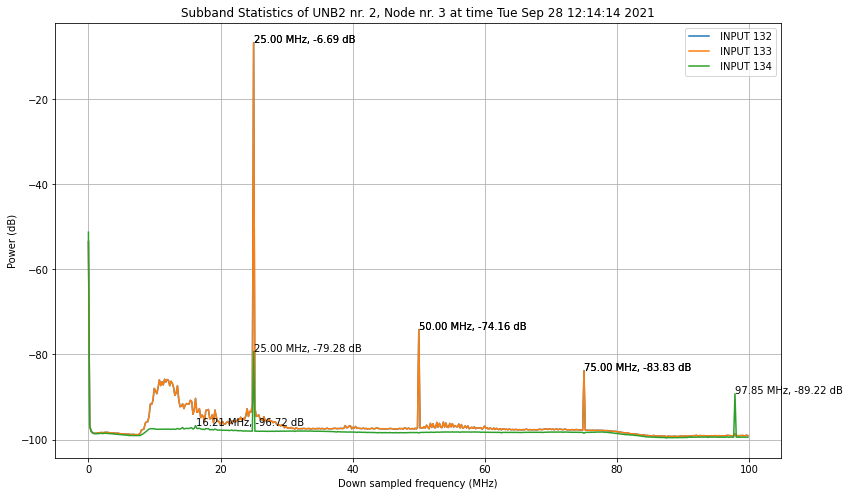

In [453]:
#
# Plot SST
#
f_as = [s/512*100 for s in range(sst.sst_r.shape[1])]
pl.figure(1, figsize=(13,8))
stri_title = "Subband Statistics of UNB2 nr. {}, Node nr. {} at time {}".format(unb2_brd, unb2_node, time.ctime(sst.last_packet_timestamp_R+2*60*60))
for ant in range((unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_start,(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_stop):
    dbfs = 10*np.log10(sst.sst_r[ant]+1)-128-6*4
    input_label = " INPUT " + str(ant)
    pl.plot(f_as, dbfs, label = input_label)
    power_min = 10*np.log10(np.min(sst.sst_r[ant])+1)-128-6*4
    power_middle = 10*np.log10(sst.sst_r[ant][250]+1)-128-6*4
    power_max = 10*np.log10(np.max(sst.sst_r[ant])+1)-128-6*4
    stri = "Ant. {} Max power is {:5.2f} dB, Min. power {:5.2f} dB, Power at 50 MHz {:5.2f} dB".format(ant, power_max, power_min, power_middle)
    print(stri)
    for harm in range(1,4):
        stri_label ="{:5.2f} MHz, {:5.2f} dB".format(freq_table[ant][harm][0], freq_table[ant][harm][1])
        pl.text(freq_table[ant][harm][0], freq_table[ant][harm][1], stri_label,horizontalalignment='left')
pl.grid(True)
pl.ylabel('Power (dB)' )
pl.xlabel('Down sampled frequency (MHz)' )
pl.legend()
pl.title(stri_title)
pl.show()

In [84]:
#
# Read Attibute list including values
#    
attr_names = pcc.get_attribute_list()
print("Atttibutes of pcc are: \n*********")
for i in attr_names:
    print(i)
print("*********\n")   

Atttibutes of pcc are: 
*********
version_R
Ant_mask_RW
CLK_Enable_PWR_R
CLK_I2C_STATUS_R
CLK_PLL_error_R
CLK_PLL_locked_R
CLK_monitor_rate_RW
CLK_translator_busy_R
HBA_element_beamformer_delays_R
HBA_element_beamformer_delays_RW
HBA_element_led_R
HBA_element_led_RW
HBA_element_LNA_pwr_R
HBA_element_LNA_pwr_RW
HBA_element_pwr_R
HBA_element_pwr_RW
RCU_ADC_lock_R
RCU_attenuator_R
RCU_attenuator_RW
RCU_band_R
RCU_band_RW
RCU_I2C_STATUS_R
RCU_ID_R
RCU_LED0_R
RCU_LED0_RW
RCU_LED1_R
RCU_LED1_RW
RCU_mask_RW
RCU_monitor_rate_RW
RCU_Pwr_dig_R
RCU_temperature_R
RCU_translator_busy_R
RCU_version_R
State
Status
*********



In [19]:
#
# Check all available attributes of SST
#  
attr_names = sst.get_attribute_list()
print("Atttibutes of sst are: \n*********")
for i in attr_names:
    print(i)
    
stri = "*********\nTime of last read packege is {}".format(time.ctime(sst.last_packet_timestamp_R))
print(stri)

Atttibutes of sst are: 
*********
version_R
nof_packets_received_R
nof_packets_dropped_R
last_packet_R
last_packet_timestamp_R
queue_collector_fill_percentage_R
queue_replicator_fill_percentage_R
replicator_clients_R
replicator_nof_packets_sent_R
replicator_nof_tasks_pending_R
nof_packets_processed_R
nof_invalid_packets_R
last_invalid_packet_R
FPGA_sst_offload_enable_RW
FPGA_sst_offload_enable_R
FPGA_sst_offload_hdr_eth_destination_mac_RW
FPGA_sst_offload_hdr_eth_destination_mac_R
FPGA_sst_offload_hdr_ip_destination_address_RW
FPGA_sst_offload_hdr_ip_destination_address_R
FPGA_sst_offload_hdr_udp_destination_port_RW
FPGA_sst_offload_hdr_udp_destination_port_R
FPGA_sst_offload_weighted_subbands_RW
FPGA_sst_offload_weighted_subbands_R
nof_valid_payloads_R
nof_payload_errors_R
sst_R
sst_timestamp_R
integration_interval_R
State
Status
*********
Time of last read packege is Mon Sep 27 08:28:10 2021


In [204]:
#
# Check all available attributes of SDP
#  
attr_names = sdp.get_attribute_list()
print("Atttibutes of sdp are: \n*********")
for i in attr_names:
    print(i)
print("*********\n")
print(sdp.State)

Atttibutes of sdp are: 
*********
version_R
FPGA_firmware_version_R
FPGA_hardware_version_R
FPGA_processing_enable_R
FPGA_processing_enable_RW
FPGA_scrap_R
FPGA_scrap_RW
FPGA_sdp_info_antenna_band_index_R
FPGA_sdp_info_block_period_R
FPGA_sdp_info_f_adc_R
FPGA_sdp_info_fsub_type_R
FPGA_sdp_info_nyquist_sampling_zone_index_R
FPGA_sdp_info_nyquist_sampling_zone_index_RW
FPGA_sdp_info_observation_id_R
FPGA_sdp_info_observation_id_RW
FPGA_sdp_info_station_id_R
FPGA_sdp_info_station_id_RW
FPGA_subband_weights_R
FPGA_subband_weights_RW
FPGA_temp_R
FPGA_weights_R
FPGA_weights_RW
FPGA_wg_amplitude_R
FPGA_wg_amplitude_RW
FPGA_wg_enable_R
FPGA_wg_enable_RW
FPGA_wg_frequency_R
FPGA_wg_frequency_RW
FPGA_wg_phase_R
FPGA_wg_phase_RW
TR_fpga_mask_R
TR_fpga_mask_RW
TR_fpga_communication_error_R
TR_software_version_R
TR_start_time_R
TR_tod_R
TR_tod_pps_delta_R
State
Status
*********

<function __get_command_func.<locals>.f at 0x7f4eb8d9a7b8>


In [462]:
#
# Enable the Sign the signal analyser for automated tests
#
# Copy from Paulus
#
import pyvisa;
def dBm2P(D): return 10**(D/10.-3);
def dB2P(D): return 10**(D/10.);
def P2dBm(D): return 10*np.log10(D)+30;

rm = pyvisa.ResourceManager()


class Instr:
    def __init__(self,IP="10.87.6.16",verbose=False):
        self.DS2 = rm.open_resource('TCPIP::'+IP+'::instr0::INSTR')
        self.verbose=verbose;
        print(self.DS2.query('*IDN?'))
    def log(self,S):
        if self.verbose: print(S)
    def write(self,S):
        self.log(self.DS2.write(S));
    def reset(self):
        self.write("*RST");


class SMB100A(Instr):
    def CWsignal(self,freq=100,Pwr=-15): #MHz,dBm
        self.write(":POW:POW "+str(Pwr)) #dBm
        self.write(":FREQ "+str(freq)+"MHz") #dBm
    def RFon(self):
        self.write(":OUTP ON")
    def RFoff(self):
        self.write(":OUTP OFF")

S1=SMB100A(IP="10.87.6.16") #Common signal

Rohde&Schwarz,SMB100A,1406.6000k03/176203,3.0.16.3-2.20.382.115



In [463]:
#
# Read old values and set new frequency / power
#
#print("Old values:")
print("Frequency:",S1.DS2.query(":FREQ?"))
print("Power:",S1.DS2.query(":POW:POW?"))

if 0:
    #S1.RFoff()
    S1.CWsignal(78.125,-54)
    print("Frequency:",S1.DS2.query(":FREQ?"))
    print("Power:",S1.DS2.query(":POW:POW?"))
    #S1.RFon();

Frequency: 25000000

Power: -17

